In [294]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [295]:
# Some helper functions
def to_homogeneous(coordinates):
    """
    Convert 2D coordinates to homogeneous coordinates.
    
    Args:
        coordinates (numpy.ndarray): Array of 2D coordinates of shape (N, 2).
    
    Returns:
        numpy.ndarray: Array of homogeneous coordinates of shape (N, 3).
    """
    # Check if the input array is a NumPy array
    if not isinstance(coordinates, np.ndarray):
        raise ValueError("Input must be a NumPy array")
    
    # Check if the input array has the correct shape
    if coordinates.shape[1] != 2:
        raise ValueError("Input array must have shape (N, 2)")
    
    # Add a column of ones to the coordinates to make them homogeneous
    homogeneous_coordinates = np.hstack((coordinates, np.ones((coordinates.shape[0], 1))))
    
    return homogeneous_coordinates

def from_homogeneous(coordinates):
    """
    Convert homogeneous coordinates to non-homogeneous coordinates.
    
    Args:
        coordinates (numpy.ndarray): Array of homogeneous coordinates of shape (N, 3).
    
    Returns:
        numpy.ndarray: Array of 2D coordinates of shape (N, 2).
    """
    # Check if the input array is a NumPy array
    if not isinstance(coordinates, np.ndarray):
        raise ValueError("Input must be a NumPy array")
    
    # Check if the input array has the correct shape
    if coordinates.shape[1] != 3:
        raise ValueError("Input array must have shape (N, 3)")
    
    # Divide the first two columns by the third column to obtain non-homogeneous coordinates
    non_homogeneous_coordinates = coordinates[:, :2] / coordinates[:, 2][:, None]
    
    return non_homogeneous_coordinates


# Essential Matrix
The essential matrix is a fundamental concept in computer vision, particularly in stereo vision and structure from motion (SfM). It represents the relationship between corresponding points in two images of a scene taken from different viewpoints.

Essentially, the essential matrix encapsulates the relative pose (orientation and position) of the cameras capturing the images. It encodes geometric constraints such as epipolar geometry, which describes how points in one image correspond to lines (epipolar lines) in the other image.

The essential matrix is crucial for tasks like stereo matching, image rectification, and 3D reconstruction, as it provides the geometric information needed to compute depth and structure from multiple views.

In the implementation below, we are assuming that we have a canonical camera (intrinsic parameters matrix K is indentity matrix)

In [354]:
img1 = cv.imread('./data/images/left1.jpg', cv.IMREAD_GRAYSCALE) 
img2 = cv.imread('./data/images/right1.jpg', cv.IMREAD_GRAYSCALE) 
 
sift = cv.SIFT_create() 
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
 
# Create BFMatcher (Brute Force Matcher)
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

pts1 = []
pts2 = [] 
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
 if m.distance < 0.8*n.distance:
     pts1.append(kp1[m.queryIdx].pt)
     pts2.append(kp2[m.trainIdx].pt)

In [355]:
# Finding essential matrix
pts1_ = np.array(pts1)
pts2_ = np.array(pts2)
E, mask = cv.findEssentialMat(pts1_, pts2_, np.eye(3), cv.RANSAC)

R1, R2, t = cv.decomposeEssentialMat(E) # decomposing the essential matrix to rotation matrices and translation
# We select only inlier points
pts1_ = pts1_[mask.ravel()==1]
pts2_ = pts2_[mask.ravel()==1]

# Fundamental Matrix
The fundamental matrix is another fundamental concept in computer vision, particularly in stereo vision and multiple view geometry. It describes the geometric relationship between corresponding points in two images of a scene taken from different viewpoints, without the need for knowledge of the camera intrinsic parameters as it inherently encapsulates such information

$F = K_2^{-T} E K_1^{-1}$, where $K_1$ and $K_2$ are the intrinsic parameter matrix for camera 1 and camera 2

In [356]:
# Finding Fundamental matrix
pts1_ = np.array(pts1)
pts2_ = np.array(pts2)
F, mask = cv.findFundamentalMat(pts1_, pts2_, cv.RANSAC)

# We select only inlier points
pts1_ = pts1_[mask.ravel()==1]
pts2_ = pts2_[mask.ravel()==1]

### Computing the Epipolar 
#cv.computeCorrespondEpilines

To find two points on the epipolar line that lie on the image boundary, we can exploit the equation of the line, which is obtained by multiplying a point in one image by the fundamental matrix. The equation of the line is given by:

$ l = F \cdot p $

Where:
- $ l $ is the equation of the epipolar line.
- $F $ is the fundamental matrix.
- $p$ is a point in one image.

The equation of a line in 2D can be represented as:

$ ax + by + c = 0$

So, for the epipolar line, \( l \), we have:

$ ax + by + c = 0 $

Given a line in this form, we can find two points on this line that lie on the image boundary by setting one of the coordinates to either 0 or the width/height of the image (depending on which boundary we want to intersect). Then, we solve for the other coordinate.


1. **Point on the Left Boundary**: To find a point on the left boundary (x = 0), we set \( x = 0 \) in the equation of the line \( ax + by + c = 0 \) and solve for \( y \). This gives us the coordinates of the point (0, \( y_0 \)).

2. **Point on the Right Boundary**: Similarly, to find a point on the right boundary (x = image width), we set \( x = \text{image width} \) in the equation of the line \( ax + by + c = 0 \) and solve for \( y \). This gives us the coordinates of the point (\( \text{image width} \), \( y_1 \)).

Once we have these two points, we can draw a line segment connecting them, which represents the epipolar line on the image.

In Python code, this process is implemented as follows:

```python
# Find a point on the left boundary (x = 0)
y0 = -c / b

# Find a point on the right boundary (x = image.shape[1])
y1 = (-c - a * image.shape[1]) / b
```

These points (0, \( y_0 \)) and (\( width \), \( y_1 \)) are the two points on the epipolar line that lie on the image boundary.

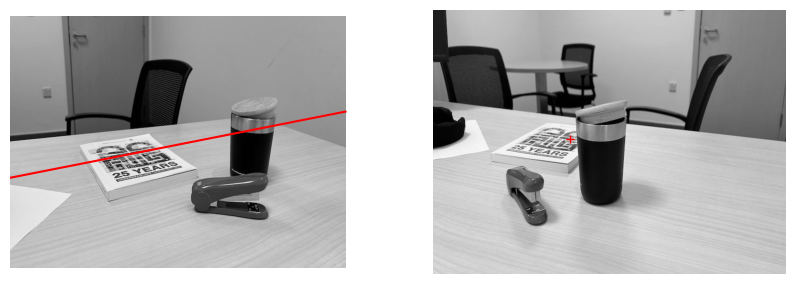

In [357]:
lines1 = to_homogeneous(pts2_).dot(F)

r,c = img1.shape

pts_index = 5

# Plots
a = lines1[pts_index, 0]
b = lines1[pts_index, 1]
c = lines1[pts_index, 2]

plt.figure(figsize=(10,6))
plt.subplot(121),plt.imshow(img1, cmap='gray'), plt.axis('off')
#img1color = cv.line(cv.cvtColor(img1, cv.COLOR_GRAY2BGR), (0, int(y0)), (640, int(y1)), [0,0,255], 1) # to draw the epipolar line on the image itself
y0 = -c/b
y1 = (- c - a * img1.shape[1]) / b
plt.plot([0, img1.shape[1]], [y0, y1], 'r')

plt.subplot(122),plt.imshow(img2, cmap='gray'), plt.axis('off')
plt.plot(pts2_[pts_index,0], pts2_[pts_index,1], 'r+')

plt.show()

# Image Rectification
Rectification is the process of finding two Homographies that make stereo images parallel, which meanstThe epipolar lines in the two images become parallel horizontal lines, all having the same y-coordinate


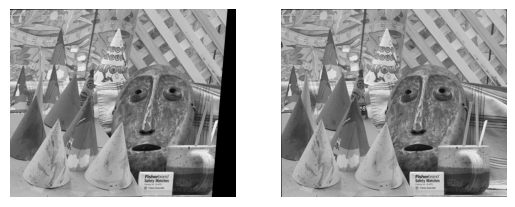

In [359]:
img1 = cv.imread('./data/images/left2.png', cv.IMREAD_GRAYSCALE) 
img2 = cv.imread('./data/images/right2.png', cv.IMREAD_GRAYSCALE) 

sift = cv.SIFT_create() 
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
 
# Create BFMatcher (Brute Force Matcher)
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

pts1 = []
pts2 = [] 
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
 if m.distance < 0.8*n.distance:
     pts1.append(kp1[m.queryIdx].pt)
     pts2.append(kp2[m.trainIdx].pt)

# Finding Fundamental matrix
pts1_ = np.array(pts1)
pts2_ = np.array(pts2)
F, mask = cv.findFundamentalMat(pts1_, pts2_, cv.RANSAC)

# We select only inlier points
pts1_ = pts1_[mask.ravel()==1]
pts2_ = pts2_[mask.ravel()==1]

h,w = img1.shape
# find the two homographies
_, H1, H2 = cv.stereoRectifyUncalibrated(pts1_, pts2_, F, (w,h))
# Appling the two homographies to the two images to rectify them
rectified_img1 = cv.warpPerspective(img1, H1, (w,h), flags=cv.INTER_LINEAR)
rectified_img2 = cv.warpPerspective(img2, H2, (w,h), flags=cv.INTER_LINEAR)


# Plots
plt.subplot(121),plt.imshow(rectified_img1, cmap='gray'), plt.axis('off')
plt.subplot(122),plt.imshow(rectified_img2, cmap='gray'), plt.axis('off')
plt.show()

# Depth Map
[Additional Reading](https://docs.opencv.org/4.x/dd/d53/tutorial_py_depthmap.html)

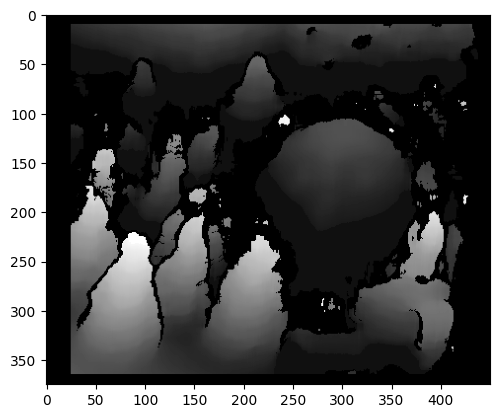

In [360]:
stereo = cv.StereoBM_create(numDisparities=16, blockSize=21)
disparity = stereo.compute(rectified_img1,rectified_img2)
plt.imshow(disparity,'gray')

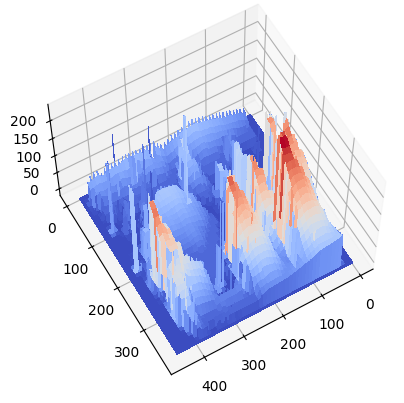

In [361]:
from matplotlib import cm

x = np.linspace(0, w, w) 
y = np.linspace(0, h, h) 
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X,Y,disparity, cmap=cm.coolwarm,
                       antialiased=False)
ax.view_init(elev=60, azim=60)